# NLP & Sentiment with News Headlines

In [3]:
#custome imports
# import loadArticles
# import loadStockInfo
# import textProcessing
from financialTextProcessing.loadStockInfo import loadStockInfo as loadStock
import financialTextProcessing.textProcessing as tp
from financialTextProcessing.createWord2Vec import word2vec
from financialTextProcessing.modeling import modeling
import financialTextProcessing.plotBacktrade as plotBt 

In [4]:
import pandas as pd
import numpy as np

#text processing
import string
import en_core_web_lg
from spacy.gold import GoldParse
from spacy.pipeline import EntityRecognizer
from spacy.tokens import Doc
from spacy.pipeline import EntityRuler

In [5]:
#sklearn imports
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
#plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
#tensor flow imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import Accuracy, Recall, Precision
#gensim imports for word 2 vec
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

In [136]:
#load stock info
stock_info = loadStock("../data/stock_info/stocks/", "../data/stock_info/symbols_valid_meta.csv", DEBUG=True)
#load stock historical data from csvs
stock_df = stock_info.loadStockDf()
#separatley load stock meta to have list of symbols and company names
stock_meta_df = stock_info.loadStockMetaDf()

In [137]:
#load in news/sentiment data
news_sent_by_ticker = pd.read_csv("../data/news/final_news_sent.csv")
#change date to datetime object
news_sent_by_ticker['date'] = pd.to_datetime(pd.to_datetime(news_sent_by_ticker['date'], utc=True).dt.date)
#change sentimet

In [138]:
#Label Encoding of Sentiment
label_encoder = LabelEncoder()
news_sent_by_ticker['sentiment_value'] = label_encoder.fit_transform(news_sent_by_ticker['sentiment'])

In [139]:
#one hot encoding of sentiment
encoder = OneHotEncoder()
one_hot_df = pd.DataFrame(encoder.fit_transform(news_sent_by_ticker[['sentiment_value']]).toarray())

In [140]:
news_sent_by_ticker = news_sent_by_ticker.join(one_hot_df)
news_sent_by_ticker.columns = ['ticker', 'title', 'sentiment', 'date', 'sentiment_value', 'is_negative', 'is_neutral', 'is_positive']

In [141]:
news_sent_by_ticker = news_sent_by_ticker[news_sent_by_ticker['date'] > '2019-01-01']

In [160]:

news_sent_by_ticker['sentiment'] = np.where(news_sent_by_ticker['sentiment']=='Neutral', 0, news_sent_by_ticker['sentiment'])
news_sent_by_ticker['sentiment'] = np.where(news_sent_by_ticker['sentiment']=='Positive', 1, news_sent_by_ticker['sentiment'])
news_sent_by_ticker['sentiment'] = np.where(news_sent_by_ticker['sentiment']=='Negative', -1, news_sent_by_ticker['sentiment'])

In [143]:
#load in stock data purely to be used to enhance the rules for entity detection in the spacy nlp
stock_meta_df['Tag'] = 'ORG'
symbol_df = stock_meta_df[stock_meta_df['ETF'] == 'N']['NASDAQ Symbol']
symbol_df.reset_index(inplace=True, drop=True)

Distribution of Sentiment

<IPython.core.display.Javascript object>

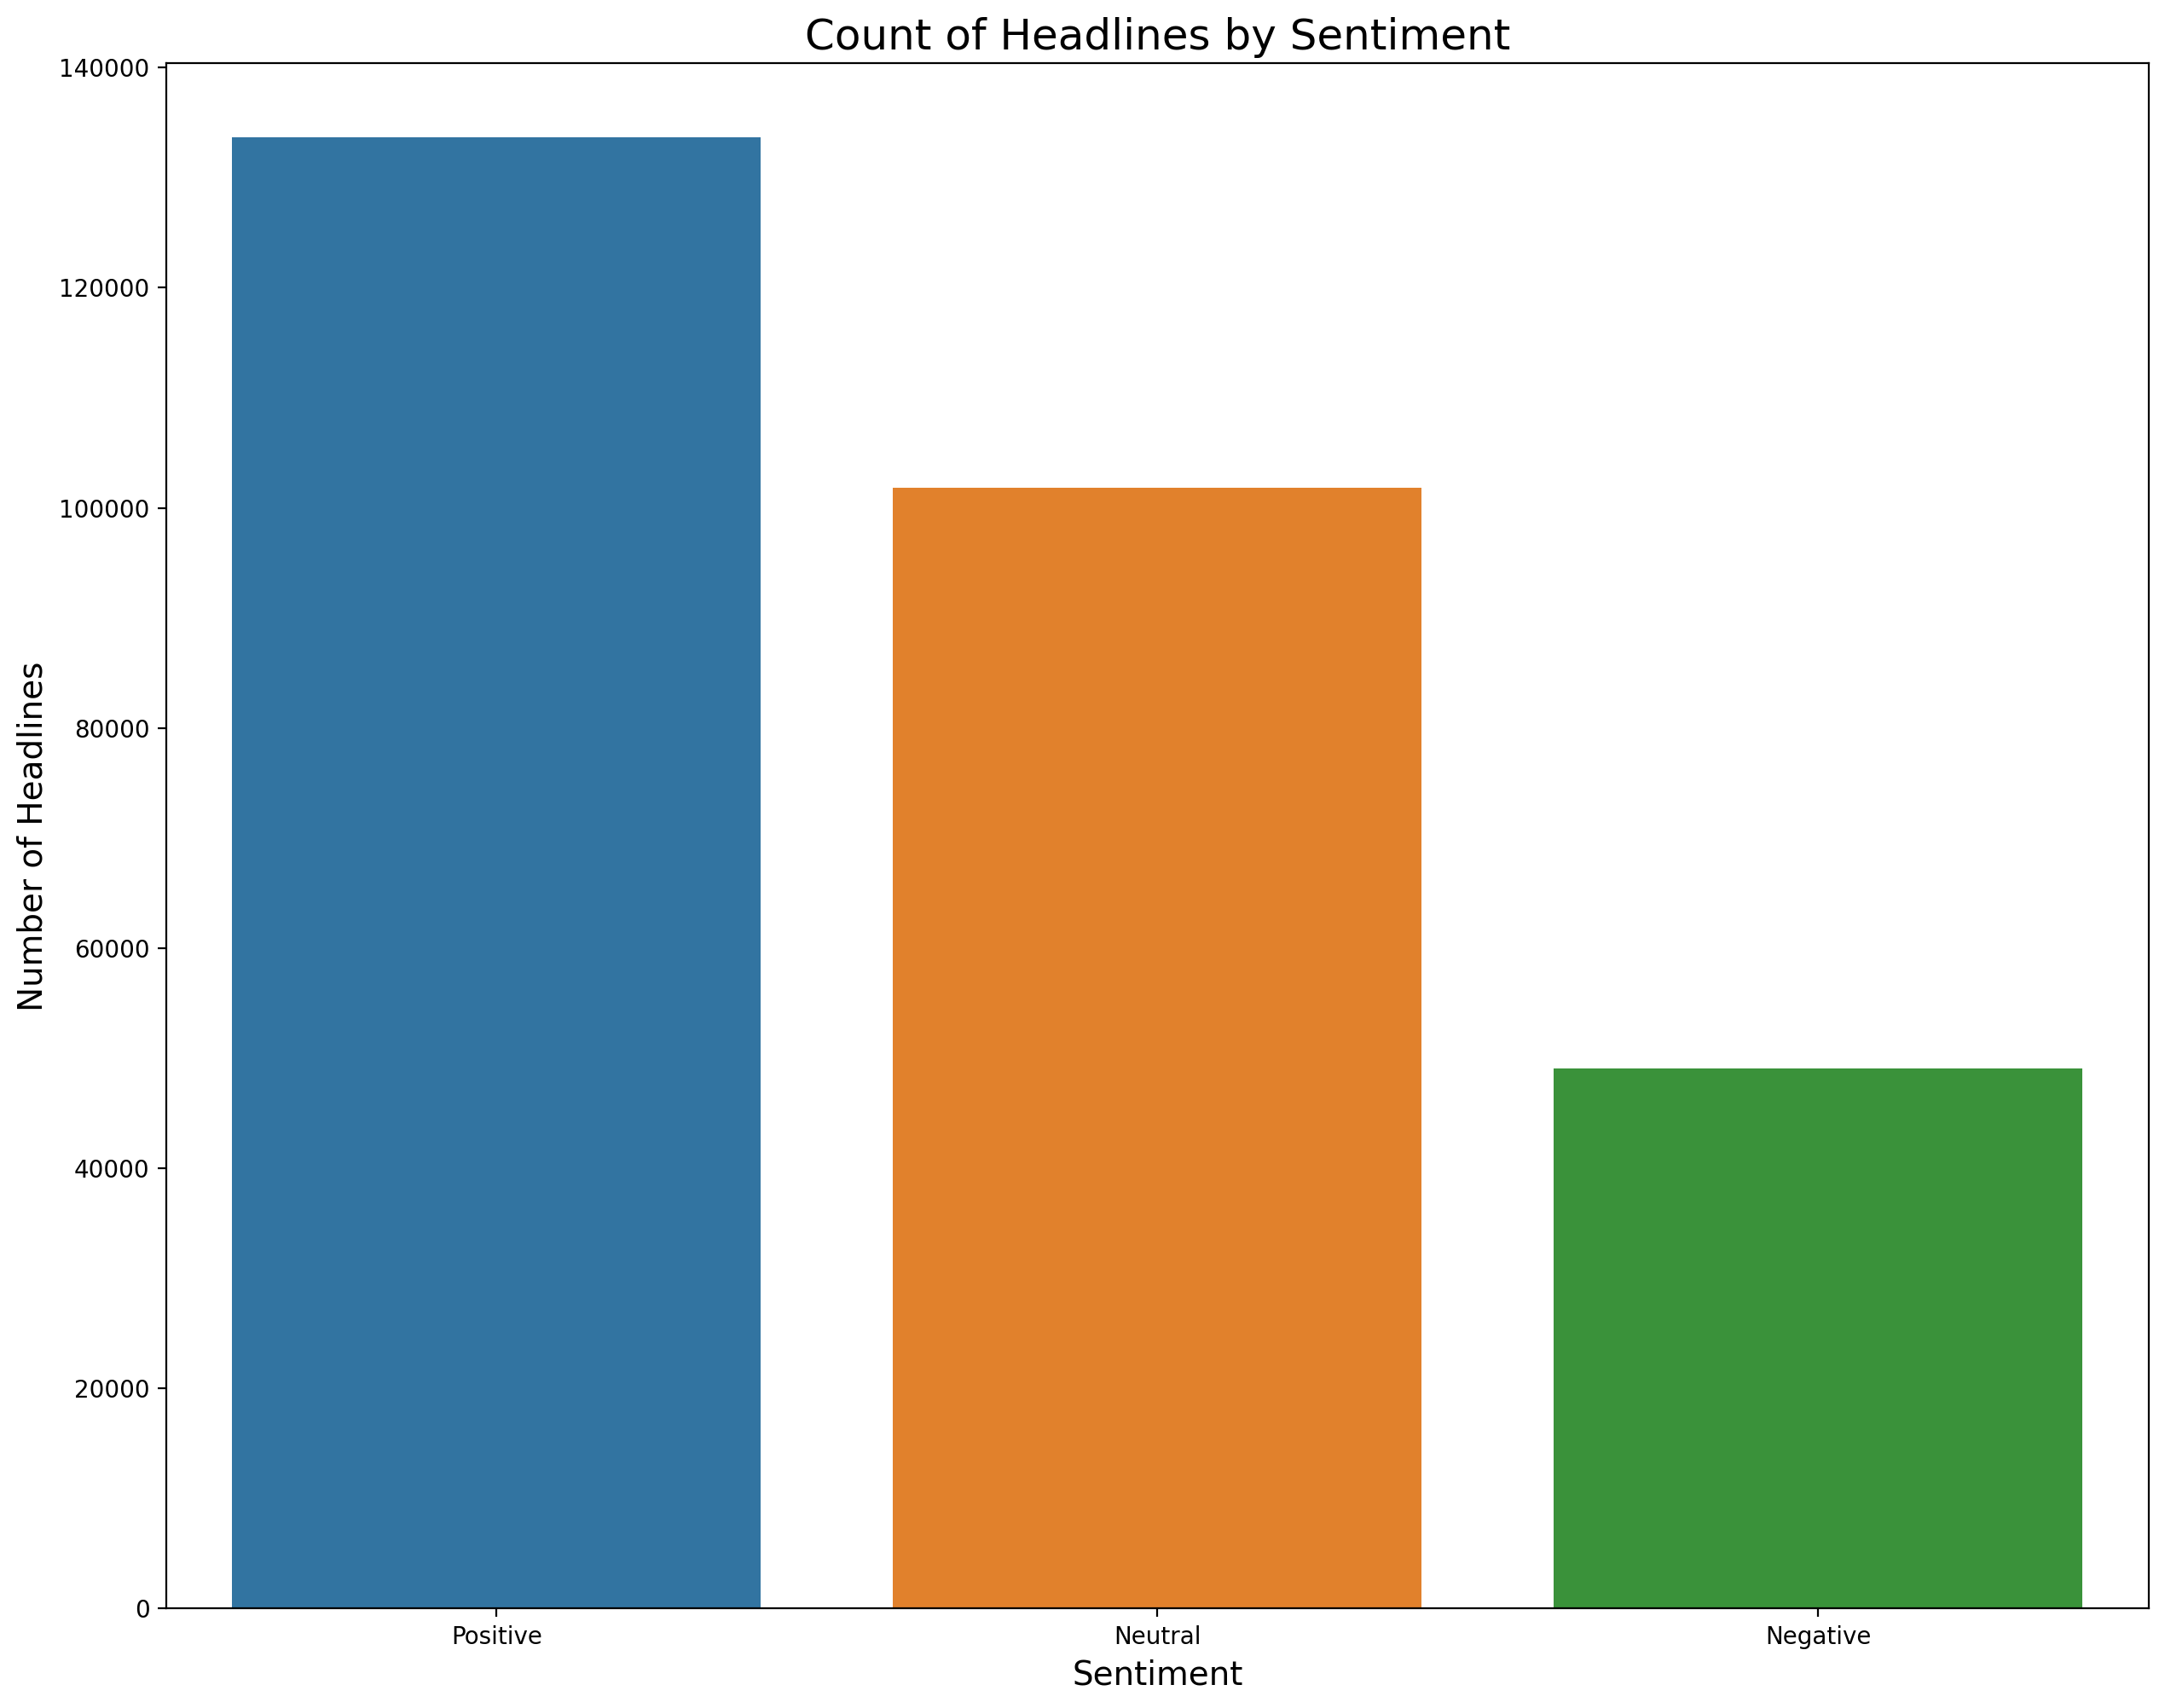

In [337]:
plt.figure(figsize=(15,12))
sns.barplot(x=news_sent_by_ticker['sentiment'].value_counts().index, y=news_sent_by_ticker['sentiment'].value_counts())
plt.xlabel("Sentiment", size=14)
plt.ylabel("Number of Headlines", size=14)
plt.title("Count of Headlines by Sentiment", size=18)
plt.show()

Distribution of Sentiment by Date

In [415]:
negative_sent_by_date = news_sent_by_ticker.query('sentiment == "Negative"').groupby('date').count()['sentiment_value']
positive_sent_by_date = news_sent_by_ticker.query('sentiment == "Positive"').groupby('date').count()['sentiment_value']
neutral_sent_by_date = news_sent_by_ticker.query('sentiment == "Neutral"').groupby('date').count()['sentiment_value']

In [372]:
print(negative_sent_by_date.shape, positive_sent_by_date.shape, neutral_sent_by_date.shape)

(473, 6) (486,) (518,)


In [423]:
negative_sent_by_date

date
2019-02-07     2
2019-02-08     1
2019-02-14     1
2019-02-21     2
2019-02-22     5
              ..
2020-06-06    32
2020-06-07     4
2020-06-08    51
2020-06-09    77
2020-06-10    69
Name: sentiment_value, Length: 473, dtype: int64

<IPython.core.display.Javascript object>

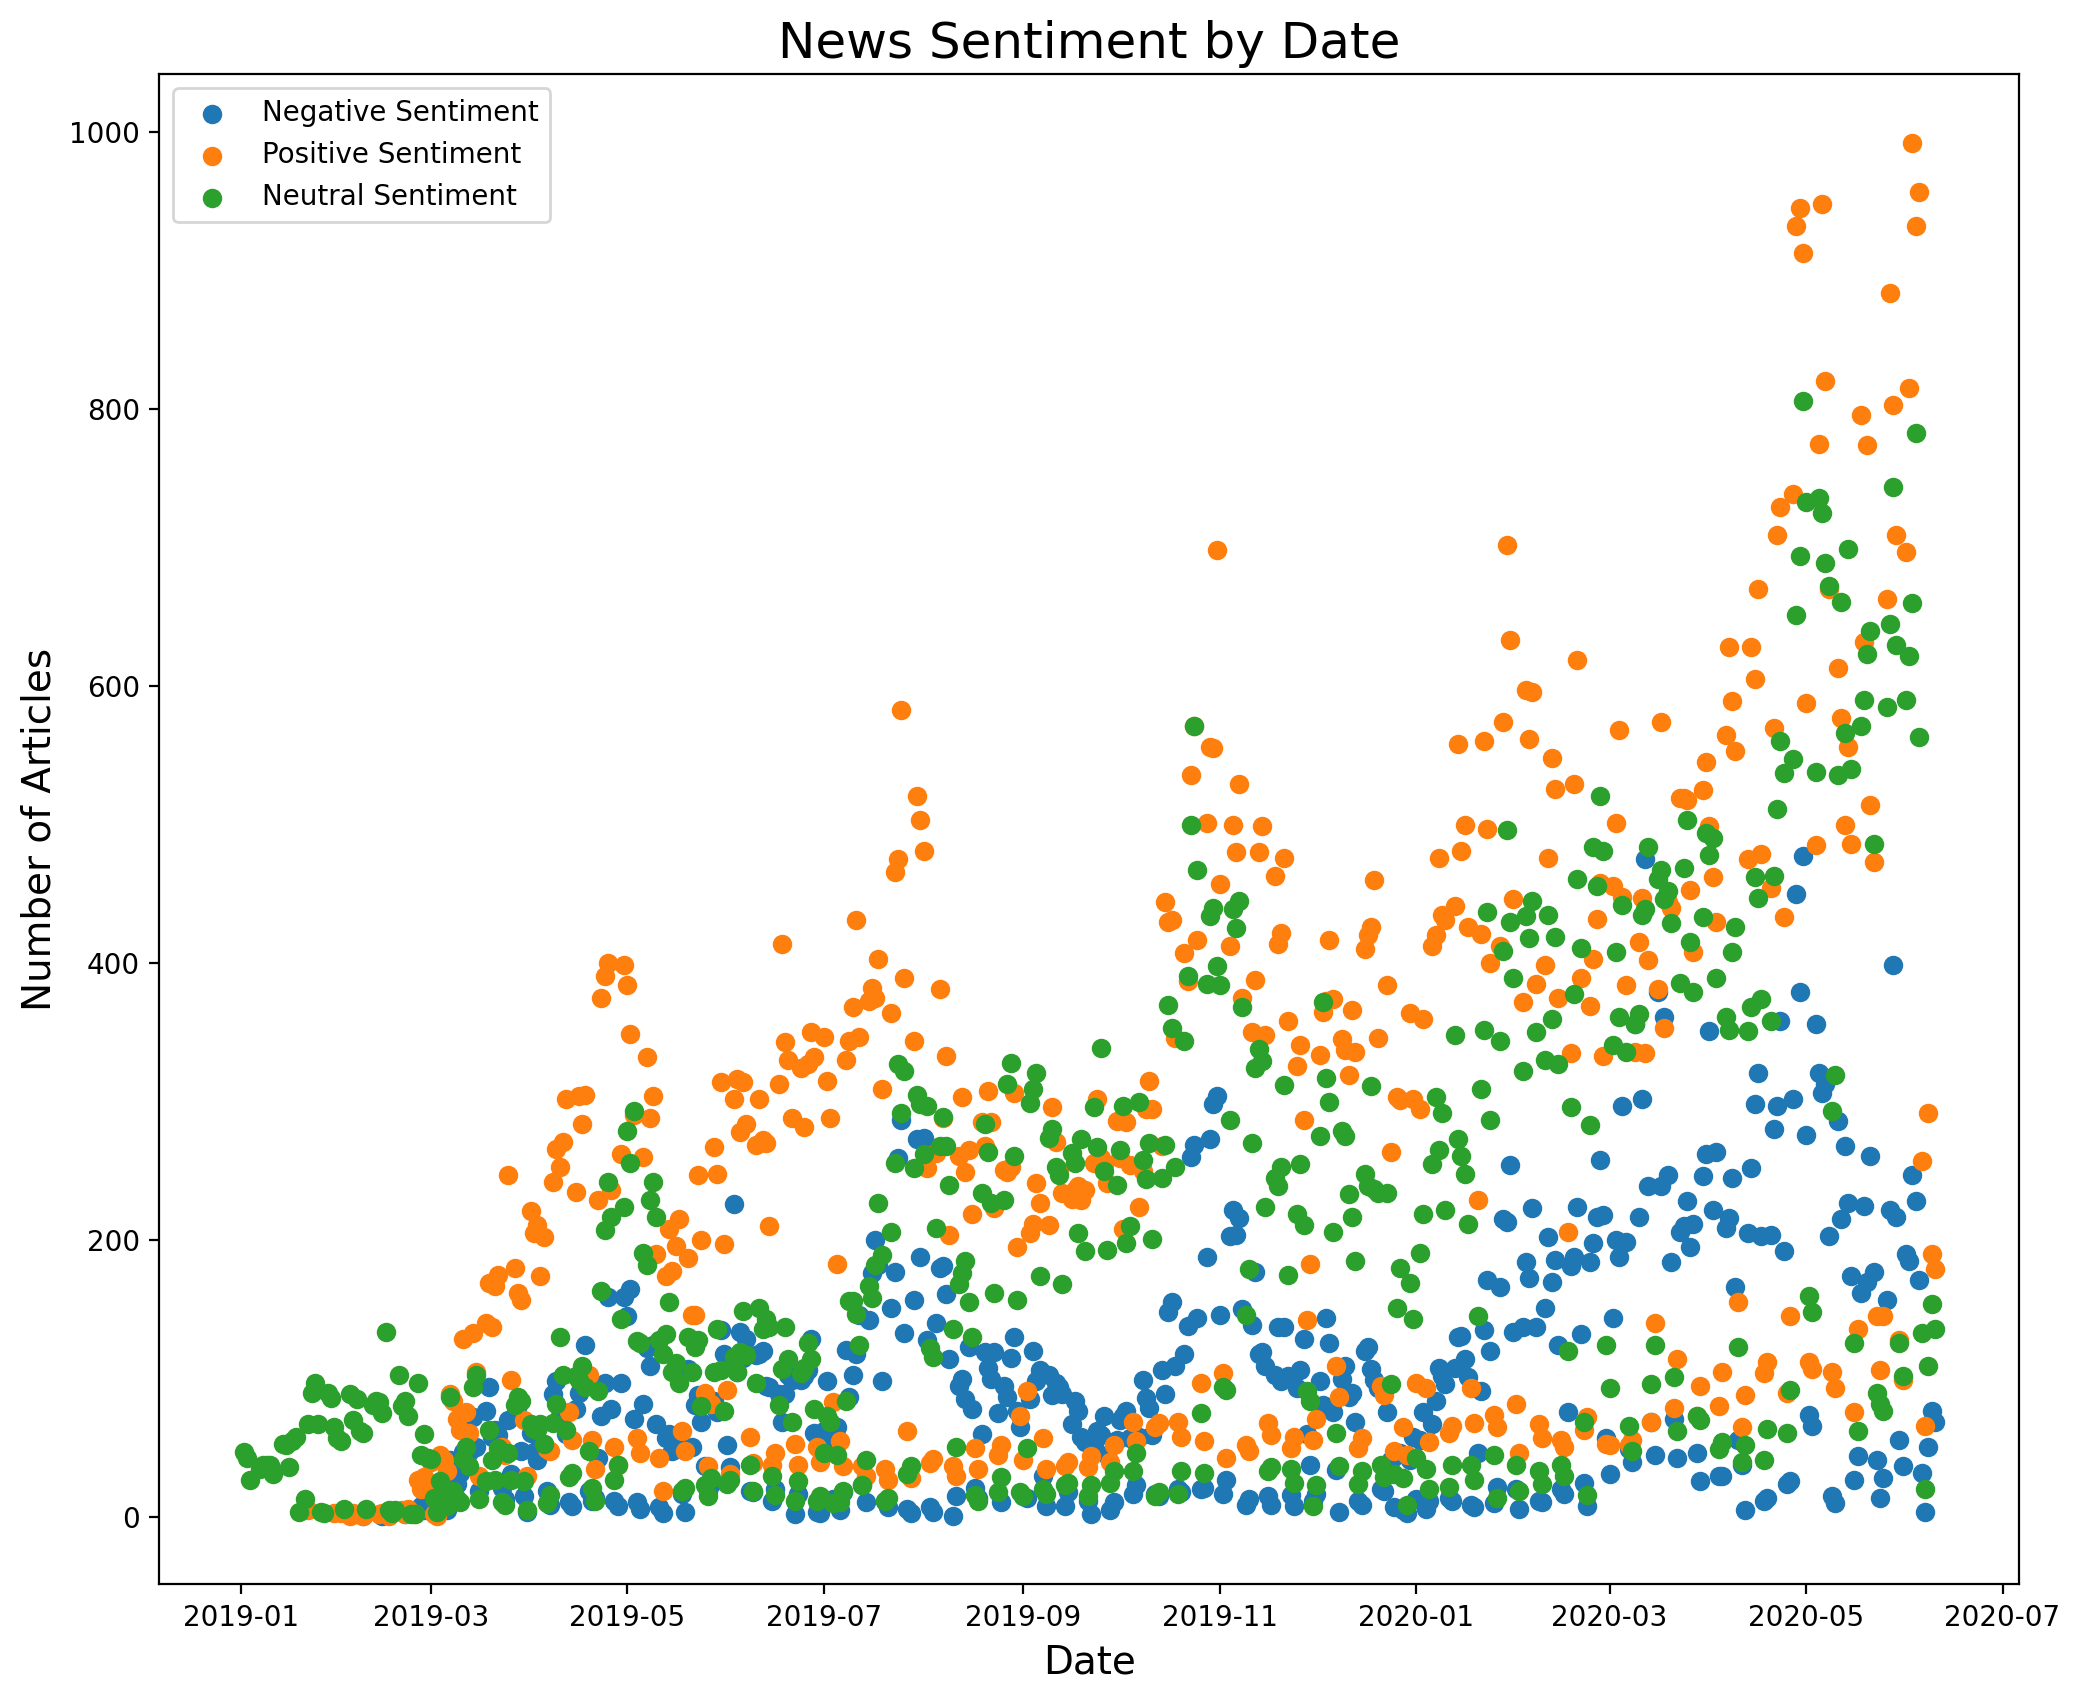

In [430]:
plt.figure(figsize=(12,10))
plt.scatter(negative_sent_by_date.index, negative_sent_by_date.values, label='Negative Sentiment')
plt.scatter(positive_sent_by_date.index, positive_sent_by_date.values, label='Positive Sentiment')
plt.scatter(neutral_sent_by_date.index, neutral_sent_by_date.values, label='Neutral Sentiment')
plt.xlabel("Date", size=14)
plt.ylabel("Number of Articles", size=14)
plt.title("News Sentiment by Date", size=18)
plt.legend()
plt.show()
plt.savefig("news_sentiment_by_date.png")

In [32]:
#improving text processing spacy tokenizer
#create more fine tuned nlp rules for spacy
#get entities from article headline
nlp = en_core_web_lg.load()
ruler = EntityRuler(nlp)

#creating pattersn for entity ruler
temp_df1 = stock_meta_df[['Tag', 'Symbol']]
temp_df1.columns = ['label', 'pattern']
temp_df2 = stock_meta_df[['Tag', 'Name']]
temp_df2.columns = ['label', 'pattern']

temp_df = pd.concat([temp_df1, temp_df2])

#set patterns
patterns = temp_df.to_dict('records')
#add patterns to ruler
ruler.add_patterns(patterns)
#add ruler to nlp
nlp.add_pipe(ruler)

tp = textProcessing.textProcessing(nlp)

In [33]:
#spacy tokenize function to use for countvectorizer and TF-IDF
#create tokenizing function
def tokenizeSpacy(sentence):
    try:
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            sentence = sentence.replace(punctuation_mark,'').lower()

        doc = nlp(sentence)

        listofwords = list()
        for token in doc:
           
            if not token.is_stop:
                if token.is_alpha:
                    listofwords.append(token.lemma_.strip().lower())

        return listofwords
    except Exception as e:
        print(f"Something went wrong in tokenizeSpacy: {e}")

## Train, Test Split

In [30]:
#split data using sentiment_value single (just two classes)
X = news_sent_by_ticker[news_sent_by_ticker['sentiment_value'] != 1]['title']
y = news_sent_by_ticker[news_sent_by_ticker['sentiment_value'] != 1]['sentiment_value']

In [33]:
#resample y sentiment for two classes
print(f"Shape of Positive Reviews Before Upsample: {X[y == 2].shape}")
print(f"Shape of Negative Reviews Before Upsample: {X[y == 0].shape}")

Shape of Positive Reviews Before Upsample: (133725,)
Shape of Negative Reviews Before Upsample: (49087,)


In [34]:
#using label encoded sentiment instead (all 3 classes)
X = news_sent_by_ticker['title']
y = news_sent_by_ticker[['is_negative', 'is_neutral', 'is_positive']]

In [35]:
#resample y sentiment
print(f"Shape of Positive Reviews Before Upsample: {X[y['is_positive'] == 1].shape}")
print(f"Shape of Neutral Reviews Before Upsample: {X[y['is_neutral'] == 1].shape}")
print(f"Shape of Negative Reviews Before Upsample: {X[y['is_negative'] == 1].shape}")

Shape of Positive Reviews Before Upsample: (133725,)
Shape of Neutral Reviews Before Upsample: (108401,)
Shape of Negative Reviews Before Upsample: (49087,)


In [36]:
print(f"Number of Negative Reviews Before: {X[y['is_negative']==1].shape}")

#upsample negative reviews to try and compensate for imbalance
X_upsample, y_upsample = resample(X[y['is_negative'] == 1], y[y['is_negative'] == 1], replace=True, n_samples=X[y['is_positive'] == 1].shape[0], random_state=123)

print(f"Number of Negative Reviews Before: {X_upsample.shape}")

Number of Negative Reviews Before: (49087,)
Number of Negative Reviews Before: (133725,)


In [37]:
#combine upsample with original for balanced set
X_balanced = np.hstack((X[y['is_negative'] == 0], X_upsample))
y_balanced = np.vstack((y[y['is_negative'] == 0], y_upsample))

In [51]:
print(f"Shape of Positive Reviews After Upsample: {X_balanced[y_balanced == 2].shape}")
print(f"Shape of Negative Reviews After Upsample: {X_balanced[y_balanced == 0].shape}")

Shape of Positive Reviews After Upsample: (133725,)
Shape of Negative Reviews After Upsample: (133725,)


In [ ]:
#change the positive from 2 to 1 for binary work
y_balanced = np.where(y_balanced == 2, 1, y_balanced)

In [22]:
#train test, validate split
X_remainder, X_test, y_remainder, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=1)

## CountVectorizer

In [56]:
#countvectorize model using a max 1000 feautres
countVectorizer = CountVectorizer(tokenizer=tokenizeSpacy, min_df=10, ngram_range=(1,3), max_features=1000)

In [57]:
countVectorizer.fit(X_train)
#transform with CountVectorizer
X_train_cv = countVectorizer.transform(X_train)
X_validate_cv = countVectorizer.transform(X_validate)

/home/jj/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [58]:
X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=countVectorizer.get_feature_names())
X_validate_cv_df = pd.DataFrame(X_validate_cv.toarray(), columns=countVectorizer.get_feature_names())

## TF-IDF Vectorizer

In [59]:
tfidf = TfidfVectorizer(max_features=1000, min_df=10, tokenizer=tokenizeSpacy, ngram_range = (1,3))

In [60]:
#fit TF-IDF model with training data
tfidf.fit(X_train)
#transform with TF-IDF
X_train_tfidf = tfidf.transform(X_train)
X_validate_tfidf = tfidf.transform(X_validate)

/home/jj/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [61]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())
X_validate_tfidf_df = pd.DataFrame(X_validate_tfidf.toarray(), columns=tfidf.get_feature_names())

## TensorFlow RNN

In [11]:
#tokenize with tensorflow will be used for RNN for embedding and without
tk = Tokenizer(lower=True, filters=string.punctuation, split=' ')

In [41]:
#fit tokenizer on balanced titles
tk.fit_on_texts(X_balanced)

### No Word Embeddings

In [47]:
#set max_len of article headlines
max_len = 25
#get tokenized titles
tokenized_title = tk.texts_to_sequences(X_balanced)
tokenized_title_X = pad_sequences(tokenized_title, maxlen=max_len)

In [48]:
#train test split on new tk vectors
X_remainder, X_test, y_remainder, y_test = train_test_split(tokenized_title_X, y_balanced, test_size=0.2, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=1)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(210476, 25) (210476, 3)
(90204, 25) (90204, 3)
(75171, 25) (75171, 3)


In [49]:
#set up a tensorflow keras neural networkd
embed_dim = 25
lstm_out = 100
max_features = tokenized_title_X.max() + 1
# learnRate = 0.001
# warmup_epoch = 20

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = tokenized_title_X.shape[1]))
model.add(LSTM(100))
# model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(3,activation='softmax'))


model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy', Precision(), Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 25)            1178725   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               50400     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 1,229,428
Trainable params: 1,229,428
Non-trainable params: 0
_________________________________________________________________


In [50]:
my_callbacks = [
    EarlyStopping(patience=2),
    ModelCheckpoint(filepath='model-3class.{epoch:02d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir='./logs')
]


model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(X_validate, y_validate),
          callbacks=my_callbacks)

Epoch 1/10
3289/3289 [==============================] - 145s 44ms/step - loss: 0.4898 - accuracy: 0.7997 - precision: 0.8441 - recall: 0.7490 - val_loss: 0.4115 - val_accuracy: 0.8352 - val_precision: 0.8592 - val_recall: 0.8085
Epoch 2/10
3289/3289 [==============================] - 137s 42ms/step - loss: 0.3423 - accuracy: 0.8668 - precision: 0.8854 - recall: 0.8473 - val_loss: 0.3739 - val_accuracy: 0.8525 - val_precision: 0.8701 - val_recall: 0.8352
Epoch 3/10
3289/3289 [==============================] - 112s 34ms/step - loss: 0.2697 - accuracy: 0.8963 - precision: 0.9099 - recall: 0.8831 - val_loss: 0.3702 - val_accuracy: 0.8598 - val_precision: 0.8744 - val_recall: 0.8439
Epoch 4/10
3289/3289 [==============================] - 123s 37ms/step - loss: 0.2185 - accuracy: 0.9160 - precision: 0.9259 - recall: 0.9063 - val_loss: 0.3789 - val_accuracy: 0.8675 - val_precision: 0.8772 - val_recall: 0.8568
Epoch 5/10
3289/3289 [==============================] - 122s 37ms/step - loss: 0.179

In [51]:
#run on test set see how it performs
scores = model.evaluate(X_test, y_test, verbose=1)
print(f"test Accuracy on Simple RNN: {scores[1]}")

2350/2350 [==============================] - 11s 5ms/step - loss: 0.4010 - accuracy: 0.8705 - precision: 0.8796 - recall: 0.8630
test Accuracy on Simple RNN: 0.8705351948738098


### Genism Word Embeddings

In [138]:
#set max_len of article headlines
max_len = 250
#get tokenized titles
tokenized_title = tk.texts_to_sequences(X_balanced)
tokenized_title_X = pad_sequences(tokenized_title, maxlen=max_len)

In [139]:
#train test split on new tk vectors
X_remainder, X_test, y_remainder, y_test = train_test_split(tokenized_title_X, y_balanced, test_size=0.2, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=1)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(210476, 250) (210476, 3)
(90204, 250) (90204, 3)
(75171, 250) (75171, 3)


In [140]:
#function to build embedded word matrix
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

In [141]:
#load model for pre trained models
filename = "data/bi-gram-model.txt"
model = KeyedVectors.load_word2vec_format(filename, binary=False)
embed_size = 250
max_features = tokenized_title_X.max() + 1

In [142]:
#get embedding matrix
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(filename))
word_index = tk.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))

#create embedded word vectors
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [162]:
#Neural Network with genism word embeddings
model2 = Sequential()

#embedd layer
model2.add(Embedding(nb_words+1, 250, weights = [embedding_matrix], trainable=False, input_length=250))

# model2.add(LSTM(1024, activation='relu', return_sequences=True))
# model2.add(Dropout(0.2))
# model2.add(BatchNormalization())


model2.add(LSTM(512, activation='relu'))
model2.add(Dropout(0.2))
# model2.add(BatchNormalization())

# model2.add(Dense(32, activation='relu'))
# model2.add(Dropout(0.2))

model2.add(Dense(3, activation='softmax'))

embedding_matrix.shape[1]

model2.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy', Recall(), Precision()])
           
model2.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 250, 250)          11787250  
_________________________________________________________________
lstm_30 (LSTM)               (None, 512)               1562624   
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 1539      
Total params: 13,351,413
Trainable params: 1,564,163
Non-trainable params: 11,787,250
_________________________________________________________________


In [163]:
#evaluate model
my_callbacks = [
    EarlyStopping(patience=2),
    ModelCheckpoint(filepath='model2-3class.{epoch:02d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir='./logs')
]


model2.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(X_validate, y_validate),
          callbacks=my_callbacks)

Epoch 1/10
   7/3289 [..............................] - ETA: 41:28 - loss: 1.0686 - accuracy: 0.4018 - recall_7: 0.0647 - precision_7: 0.4915

KeyboardInterrupt: 

In [264]:
#run on test set see how it performs
scores = model2.evaluate(X_test, y_test, verbose=1)
print(f"test Accuracy on Simple RNN: {scores[1]}")

1672/1672 [==============================] - 37s 22ms/step - loss: 0.3565 - accuracy: 0.8273
test Accuracy on Simple RNN: 0.8273135423660278


## Logistic Regression

In [244]:
#print shapes of CV and tfidf
print(f"Shape of TF-IDF Train: {X_train_tfidf.shape} - Shape of Validate: {X_validate_tfidf.shape}")
print(f"Shape of CountVectorizer Train: {X_train_cv.shape} - Shape of Validate: {X_validate_cv.shape}")

Shape of TF-IDF Train: (149772, 1000) - Shape of Validate: (64188, 1000)
Shape of CountVectorizer Train: (149772, 1000) - Shape of Validate: (64188, 1000)


In [62]:
print_line = "\n=======================================================\n"

In [63]:
lr_model = LogisticRegression(C=0.1, max_iter=1000)

In [77]:
# CountVectorize LogisticRegression Model
lr_model.fit(X_train_cv_df[(y_train != 1).reset_index(drop=True)], y_train[y_train != 1])

LogisticRegression(C=0.1, max_iter=1000)

In [79]:
#get predicted
y_pred = lr_model.predict(X_validate_cv_df[(y_validate != 1).reset_index(drop=True)])
report_test = classification_report(y_validate[y_validate != 1], y_pred)

print("Valid Confusion Matrix for CountVectorizer:", print_line, confusion_matrix(y_validate[y_validate != 1], y_pred))
print("\nValid Data Classification Report for CountVectorizer:", print_line, report_test)

Valid Confusion Matrix for CountVectorizer: 
 [[ 8326  3353]
 [ 1286 30855]]

Valid Data Classification Report for CountVectorizer: 
               precision    recall  f1-score   support

           0       0.87      0.71      0.78     11679
           2       0.90      0.96      0.93     32141

    accuracy                           0.89     43820
   macro avg       0.88      0.84      0.86     43820
weighted avg       0.89      0.89      0.89     43820



In [95]:
# TF-IDF Logisitc Regression Model
lr_model.fit(X_train_tfidf_df[(y_train != 1).reset_index(drop=True)], y_train[y_train != 1])

LogisticRegression(C=0.1, max_iter=1000)

In [96]:
#get predicted
y_pred = lr_model.predict(X_validate_tfidf_df[(y_validate != 1).reset_index(drop=True)])
report_test = classification_report(y_validate[y_validate != 1], y_pred)

print("Valid Confusion Matrix for TF-IDF:", print_line, confusion_matrix(y_validate[y_validate != 1], y_pred))
print("\nValid Data Classification Report for TF-IDF:", print_line, report_test)

Valid Confusion Matrix for TF-IDF: 
 [[ 7919  3760]
 [ 1048 31093]]

Valid Data Classification Report for TF-IDF: 
               precision    recall  f1-score   support

           0       0.88      0.68      0.77     11679
           2       0.89      0.97      0.93     32141

    accuracy                           0.89     43820
   macro avg       0.89      0.82      0.85     43820
weighted avg       0.89      0.89      0.89     43820



## BackTrader

In [7]:
import backtrader as bt
import os
import sys
import datetime

In [8]:
#load stock data for FB, AMZN, MSFT, GOOG
fb_stock_df = pd.read_csv("../data/current_data/fb_stock_04012020_06212020.csv")
amzn_stock_df = pd.read_csv("../data/current_data/amzn_stock_04012020_06212020.csv")
msft_stock_df = pd.read_csv("../data/current_data/msft_stock_04012020_06212020.csv")
goog_stock_df = pd.read_csv("../data/current_data/goog_stock_04012020_06212020.csv")

In [9]:
#organize sentiment data by date 
tmp_df = pd.read_csv("../data/current_data/news_last_2_months_FB_AMZN_GOOG_MSFT.csv", index_col=0)

In [16]:
news_sent_fb = tmp_df[tmp_df['ticker'] == 'FB'].drop(columns=['ticker']).set_index('date')
news_sent_amzn = tmp_df[tmp_df['ticker'] == 'AMZN'].drop(columns=['ticker']).set_index('date')
news_sent_goog = tmp_df[tmp_df['ticker'] == 'GOOG'].drop(columns=['ticker']).set_index('date')
news_sent_msft = tmp_df[tmp_df['ticker'] == 'MSFT'].drop(columns=['ticker']).set_index('date')

In [17]:
#set up a tensorflow keras neural networkd
embed_dim = 25
lstm_out = 100

In [18]:

tk = Tokenizer(lower=True, filters=string.punctuation, split=' ')#set max_len of article headlines
max_len = 25
prediction_dict = dict()
count = 0
tk.fit_on_texts(tmp_df['title'])
for df in [news_sent_fb, news_sent_amzn, news_sent_goog, news_sent_msft]:
    #get tokenized titles
    tokenized_title = tk.texts_to_sequences(df['title'])
    tokenized_title_X = pad_sequences(tokenized_title, maxlen=max_len)
    model = load_model("../../../models/model2-3class-goog_train.08-0.34.h5")
    prediction_dict[count] = np.round(model.predict(tokenized_title_X))
    count +=1

In [19]:
#fb dataframe example
news_sent_fb = np.hstack((news_sent_fb.reset_index(),prediction_dict[0]))
news_sent_fb = pd.DataFrame(news_sent_fb, columns=['date', 'title', 'is_negative', 'is_neutral', 'is_positive'])
news_sent_fb = news_sent_fb.astype({'is_negative': 'float', 'is_neutral': 'float', 'is_positive': 'float'})
news_sent_fb['date'] = pd.to_datetime(news_sent_fb['date'])
news_sent_fb['sentiment'] = None
news_sent_fb['sentiment'] = np.where(news_sent_fb['is_positive'] == 1, 1, news_sent_fb['sentiment'])
news_sent_fb['sentiment'] = np.where(news_sent_fb['is_negative'] == 1, -1, news_sent_fb['sentiment'])
news_sent_fb['sentiment'] = np.where(news_sent_fb['is_neutral'] == 1, 0, news_sent_fb['sentiment'])
news_sent_fb = news_sent_fb.astype({'sentiment': 'float'})

In [20]:
grouped_fb_news_df = news_sent_fb.groupby('date').mean().round(3)['sentiment']
date_sentiment_df = grouped_fb_news_df.to_dict()
fb_stock_df = fb_stock_df.drop(columns=['Dividends', 'Stock Splits'])
fb_stock_df.columns = ['date','open', 'high', 'low', 'close', 'volume']
fb_stock_df['date'] = pd.to_datetime(fb_stock_df['date'])

In [21]:
fb_stock_df.dtypes

date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
dtype: object

In [22]:
fb_stock_df.sort_values(by='date', inplace=True)
news_sent_fb.sort_values(by='date', inplace=True)

In [23]:
news_sent_by_ticker

NameError: name 'news_sent_by_ticker' is not defined

In [198]:
news_sent_by_ticker = news_sent_by_ticker.astype({'sentiment':'float'})
news_sent_by_ticker['date'] =pd.to_datetime(news_sent_by_ticker['date']).dt.date
news_sent_fb = news_sent_by_ticker[news_sent_by_ticker['ticker'] == "FB"][['date', 'sentiment']]
news_sent_fb.sort_values(by='date', inplace=True)
news_sent_fb = news_sent_fb.groupby('date').mean()['sentiment'].to_frame(name='sentiment')

In [170]:
fb_stock_df = stock_df.query('Symbol == "FB"').query("Date > '2019-01-01'")

In [175]:
fb_stock_df['date'] = pd.to_datetime(fb_stock_df['Date']).dt.date
fb_stock_df.set_index('date', inplace=True)

In [179]:
fb_stock_df.drop(columns=['Date', 'Symbol', 'Name'], inplace=True)
fb_stock_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

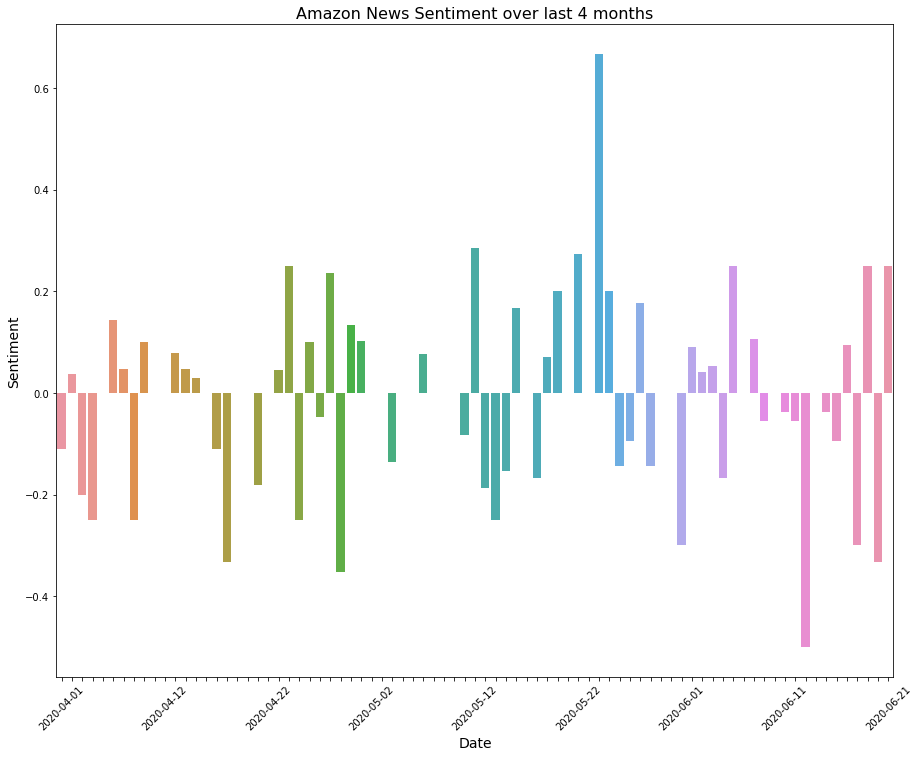

In [122]:
plt.figure(figsize=(15,12))
plot = sns.barplot(pd.to_datetime(news_sent_fb['date']).dt.date, news_sent_fb['sentiment'], ci=None)
plt.xticks(rotation=45)

for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.title("Amazon News Sentiment over last 4 months", size=16)
plt.xlabel("Date", size=14)
plt.ylabel("Sentiment", size=14)
plt.show()
fig = plot.get_figure()
fig.savefig('Amazon Sentiment Over Last 4 Months', dpi=200)

In [181]:
fb_stock_df

,open,high,low,close,adj_close,volume
date,,,,,,
2019-01-02,128.990005,137.509995,128.559998,135.679993,135.679993,28146200.0
2019-01-03,134.690002,137.169998,131.119995,131.740005,131.740005,22717900.0
2019-01-04,134.009995,138.000000,133.750000,137.949997,137.949997,29002100.0
2019-01-07,137.559998,138.869995,135.910004,138.050003,138.050003,20089300.0
2019-01-08,139.889999,143.139999,139.539993,142.529999,142.529999,26263800.0
...,...,...,...,...,...,...
2020-03-26,158.250000,164.000000,157.020004,163.339996,163.339996,26556800.0
2020-03-27,158.199997,160.089996,154.750000,156.789993,156.789993,24879900.0
2020-03-30,159.179993,166.750000,158.059998,165.949997,165.949997,22515200.0


In [182]:
fb_stock_df['change'] = fb_stock_df['close']-fb_stock_df['open']

In [183]:
fb_stock_df['change_percent'] = (fb_stock_df['change']/fb_stock_df['close'])*100

In [125]:
news_sent_fb = news_sent_fb.fillna(0)
news_sent_fb.set_index('date', inplace=True)

In [126]:
fb_stock_df.sort_values(by='date', inplace=True)
fb_stock_df.set_index('date', inplace=True)


In [194]:
news_sent_fb = news_sent_fb.groupby('date').mean()['sentiment'].to_frame(name='sentiment')

In [199]:
combine_info = pd.merge(fb_stock_df, news_sent_fb.groupby('date').mean()['sentiment'].to_frame(name='sentiment'), on='date')


,open,high,low,close,adj_close,volume,change,change_percent,sentiment
date,,,,,,,,,
2019-01-02,128.990005,137.509995,128.559998,135.679993,135.679993,28146200.0,6.689987,4.930710,0.000000
2019-01-03,134.690002,137.169998,131.119995,131.740005,131.740005,22717900.0,-2.949997,-2.239257,0.000000
2019-01-08,139.889999,143.139999,139.539993,142.529999,142.529999,26263800.0,2.639999,1.852241,0.000000
2019-01-09,142.949997,144.699997,141.270004,144.229996,144.229996,22205900.0,1.279999,0.887471,0.000000
2019-01-11,143.149994,145.360001,142.570007,143.800003,143.800003,12908000.0,0.650009,0.452023,0.000000
...,...,...,...,...,...,...,...,...,...
2020-03-26,158.250000,164.000000,157.020004,163.339996,163.339996,26556800.0,5.089996,3.116197,0.466667
2020-03-27,158.199997,160.089996,154.750000,156.789993,156.789993,24879900.0,-1.410004,-0.899294,0.500000
2020-03-30,159.179993,166.750000,158.059998,165.949997,165.949997,22515200.0,6.770004,4.079545,0.823529


In [211]:
combine_info.to_csv('test_for_tab.csv')

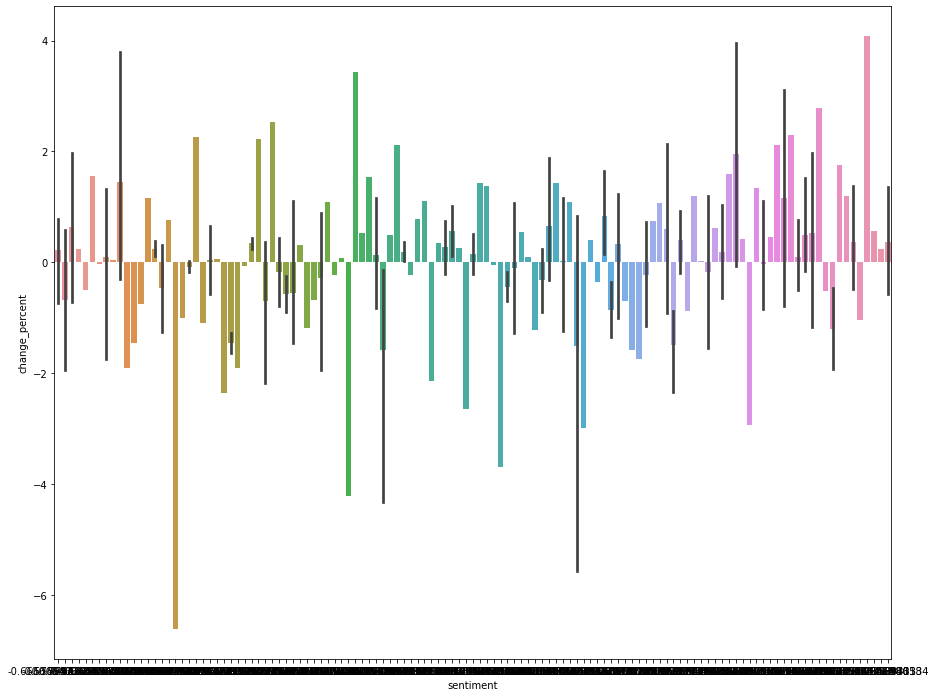

In [209]:
plt.figure(figsize=(15,12))
sns.barplot(combine_info['sentiment'], combine_info['change_percent'])

In [ ]:
plt.figure(figsize=(15,12))
plot = sns.barplot(pd.to_datetime(combine_info.index).date, combine_info['change_percent'], ci=None)
sns.lineplot(pd.to_datetime(combine_info.index).date, combine_info['sentiment'], ci=None)
plt.xticks(rotation=45)
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.title("Facebook News Sentiment over last 4 months", size=16)
plt.xlabel("Date", size=14)
plt.ylabel("Sentiment", size=14)
plt.show()
fig = plot.get_figure()
fig.savefig('Facebook Sentiment Over Last 4 Months', dpi=200)

In [24]:
date_sentiment = {}

for k in date_sentiment_df:
    date_sentiment[pd.to_datetime(k).date()] = round(date_sentiment_df[k],3)

earliest_date = min(date_sentiment.keys())

Starting Portfolio Value: 100000.00
2020-04-02, Close, 158.19 - Sentiment, 0.11
2020-04-02, BUY CREATE, 158.19 - SENTIMENT 0.17 - PREV
2020-04-03, BUY EXECUTED, Price: 157.15, Cost: 62860.00, Comm 62.86
2020-04-03, Close, 154.18 - Sentiment, 0.29
2020-04-06, Close, 165.55 - Sentiment, 0.12
2020-04-07, Close, 168.83 - Sentiment, 0.25
2020-04-08, Close, 174.28 - Sentiment, 0.18
2020-04-09, Close, 175.19 - Sentiment, 0.11
2020-04-09, SELL CREATE, 175.19 - SENTIMENT -0.51 - PREV 
2020-04-13, SELL EXECUTED, Price: 173.67, Cost: 62860.00, Comm 69.47
2020-04-13, OPERATION PROFIT, GROSS 6608.00, NET 6475.67
2020-04-13, Close, 174.79 - Sentiment, -0.40
2020-04-14, Close, 178.17 - Sentiment, 0.20
2020-04-15, Close, 176.97 - Sentiment, 0.20
2020-04-15, BUY CREATE, 176.97 - SENTIMENT 0.30 - PREV
2020-04-16, BUY EXECUTED, Price: 177.95, Cost: 71180.00, Comm 71.18
2020-04-16, Close, 176.25 - Sentiment, 0.50
2020-04-17, Close, 179.24 - Sentiment, -0.35
2020-04-21, Close, 170.80 - Sentiment, -0.12
202

<IPython.core.display.Javascript object>

[[<Figure size 2400x2000 with 3 Axes>]]

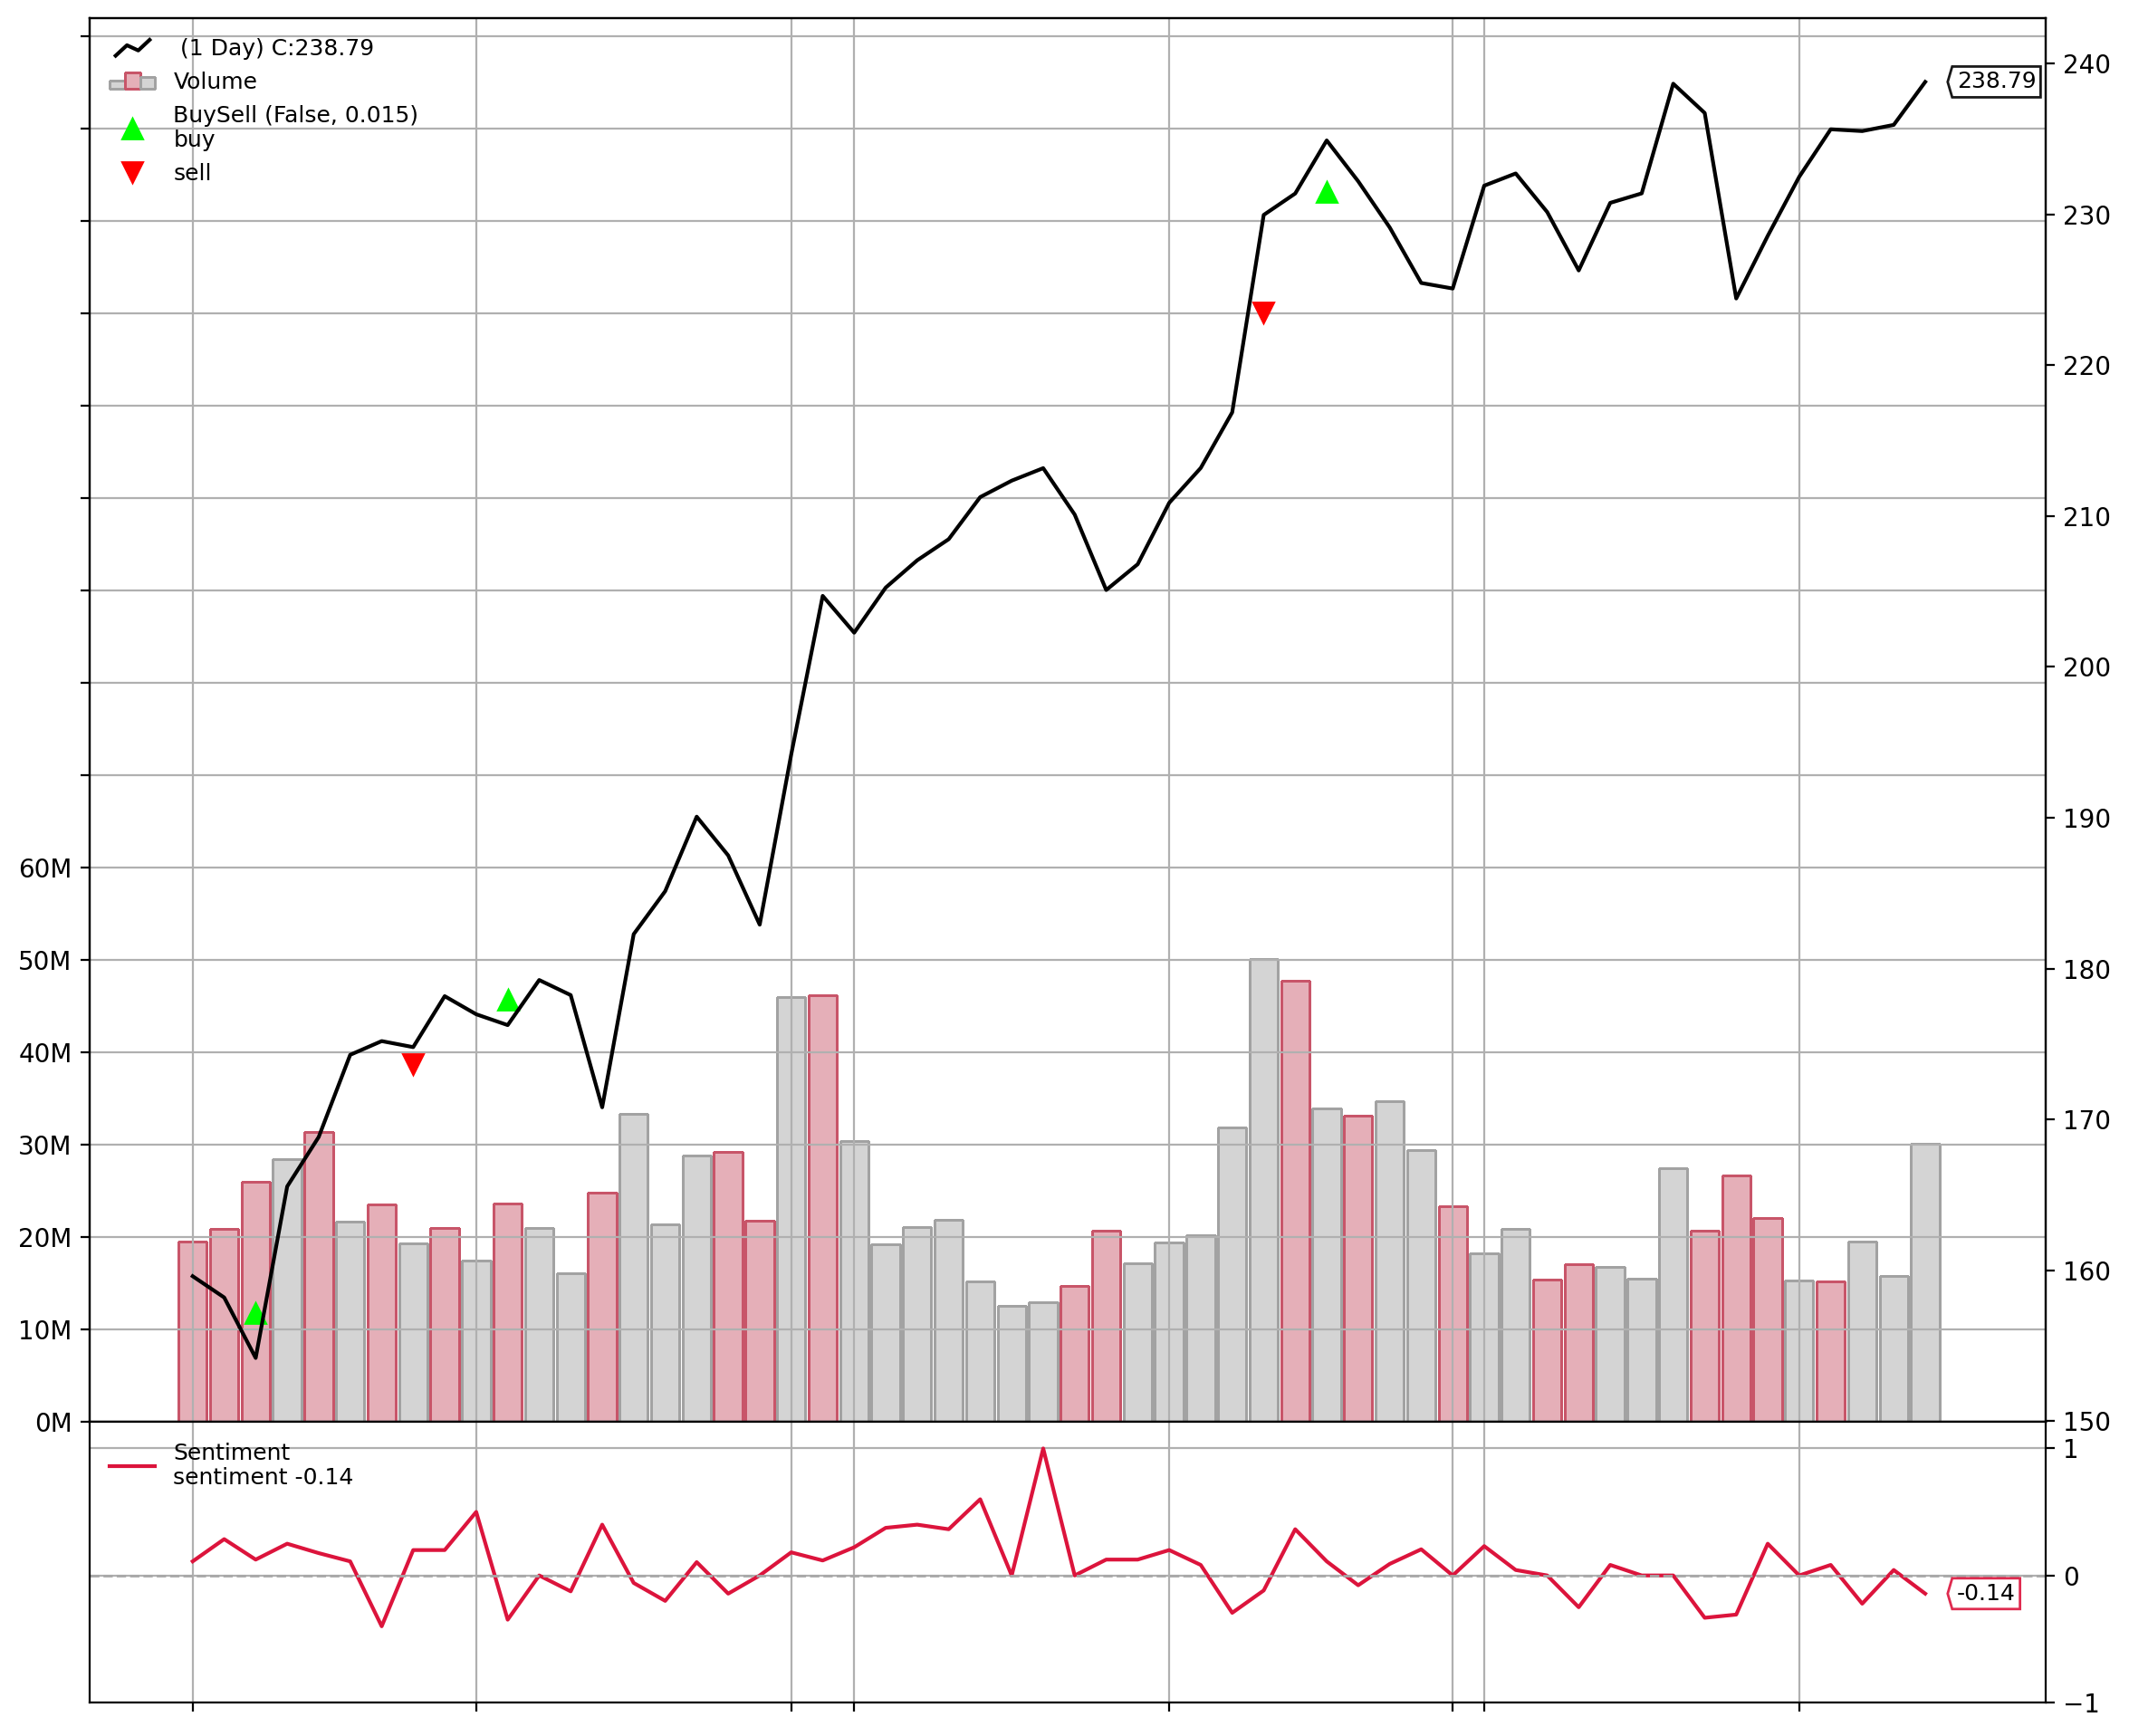

In [62]:
# Credit for this Class implementation
# Found through medium post - 
# https://towardsdatascience.com/https-towardsdatascience-com-algorithmic-trading-using-sentiment-analysis-on-news-articles-83db77966704
# Written by Jason Yip

from __future__ import (absolute_import, division, print_function,
                            unicode_literals)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        else:
            self.sentiment = 0.0
        self.lines.sentiment[0] = self.sentiment



class SentimentStrat(bt.Strategy):
    params = (
        ('period', 5),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.last_sell = 0
        self.lat_buy = 0
        self.order = None
        self.buyprice = None
        self.buycomm = None
#         self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        if self.sentiment:
            self.log('Close, %.2f - Sentiment, %.2f' % (self.dataclose[0], self.sentiment))
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            if self.sentiment > 0.25 and self.dataclose[0] > self.last_sell:
                self.log('BUY CREATE, %.2f - SENTIMENT %.2f - PREV' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
                self.last_buy = self.dataclose[0]
                self.order = self.buy()
            # buy if current close more than sma AND sentiment increased by >= 0.5
#             elif self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment > 0.25:
# #             if self.sentiment - prev_sentiment > 0.25:
#                 self.log('BUY CREATE, %.2f - SENTIMENT %.2f' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
#                 self.last_buy = self.dataclose[0]
#                 self.order = self.buy()
#                 print(self.last_sell, self.last_buy)
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
#             if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment < -0.25:
# #             if self.sentiment - prev_sentiment < -0.25:
#                 self.log('SELL CREATE, %.2f - SENTIMENT %.2f' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
#                 self.last_sell = self.dataclose[0]
#                 self.order = self.sell()
            if self.sentiment < -0.25 and self.last_buy < self.dataclose[0]:
                self.log('SELL CREATE, %.2f - SENTIMENT %.2f - PREV ' % (self.dataclose[0], (self.sentiment - prev_sentiment)))
                self.last_sell = self.dataclose[0]
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' % (self.params.period, self.broker.getvalue()), doprint=True)
        

# if __name__ == '__main__':
cerebro = bt.Cerebro(stdstats=False)

# Strategy
cerebro.addstrategy(SentimentStrat)

# Data Feed
data = bt.feeds.PandasData(dataname=fb_stock_df.set_index('date'))

cerebro.adddata(data)

cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=400)
cerebro.broker.setcommission(commission=0.001)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.run()

plt.rcParams['figure.figsize']=[12, 10]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
plt.title("Facebook from 01/01/2020 - 01/04/2020")
cerebro.plot(start=min(fb_stock_df['date']).date(), end=max(fb_stock_df['date']).date())
saveplots(cerebro, file_path = 'fb_stock_over_last_4mnths.png')

In [61]:
min(fb_stock_df['date']).date()

datetime.date(2020, 4, 1)

<IPython.core.display.Javascript object>

[[<Figure size 2400x2000 with 4 Axes>]]

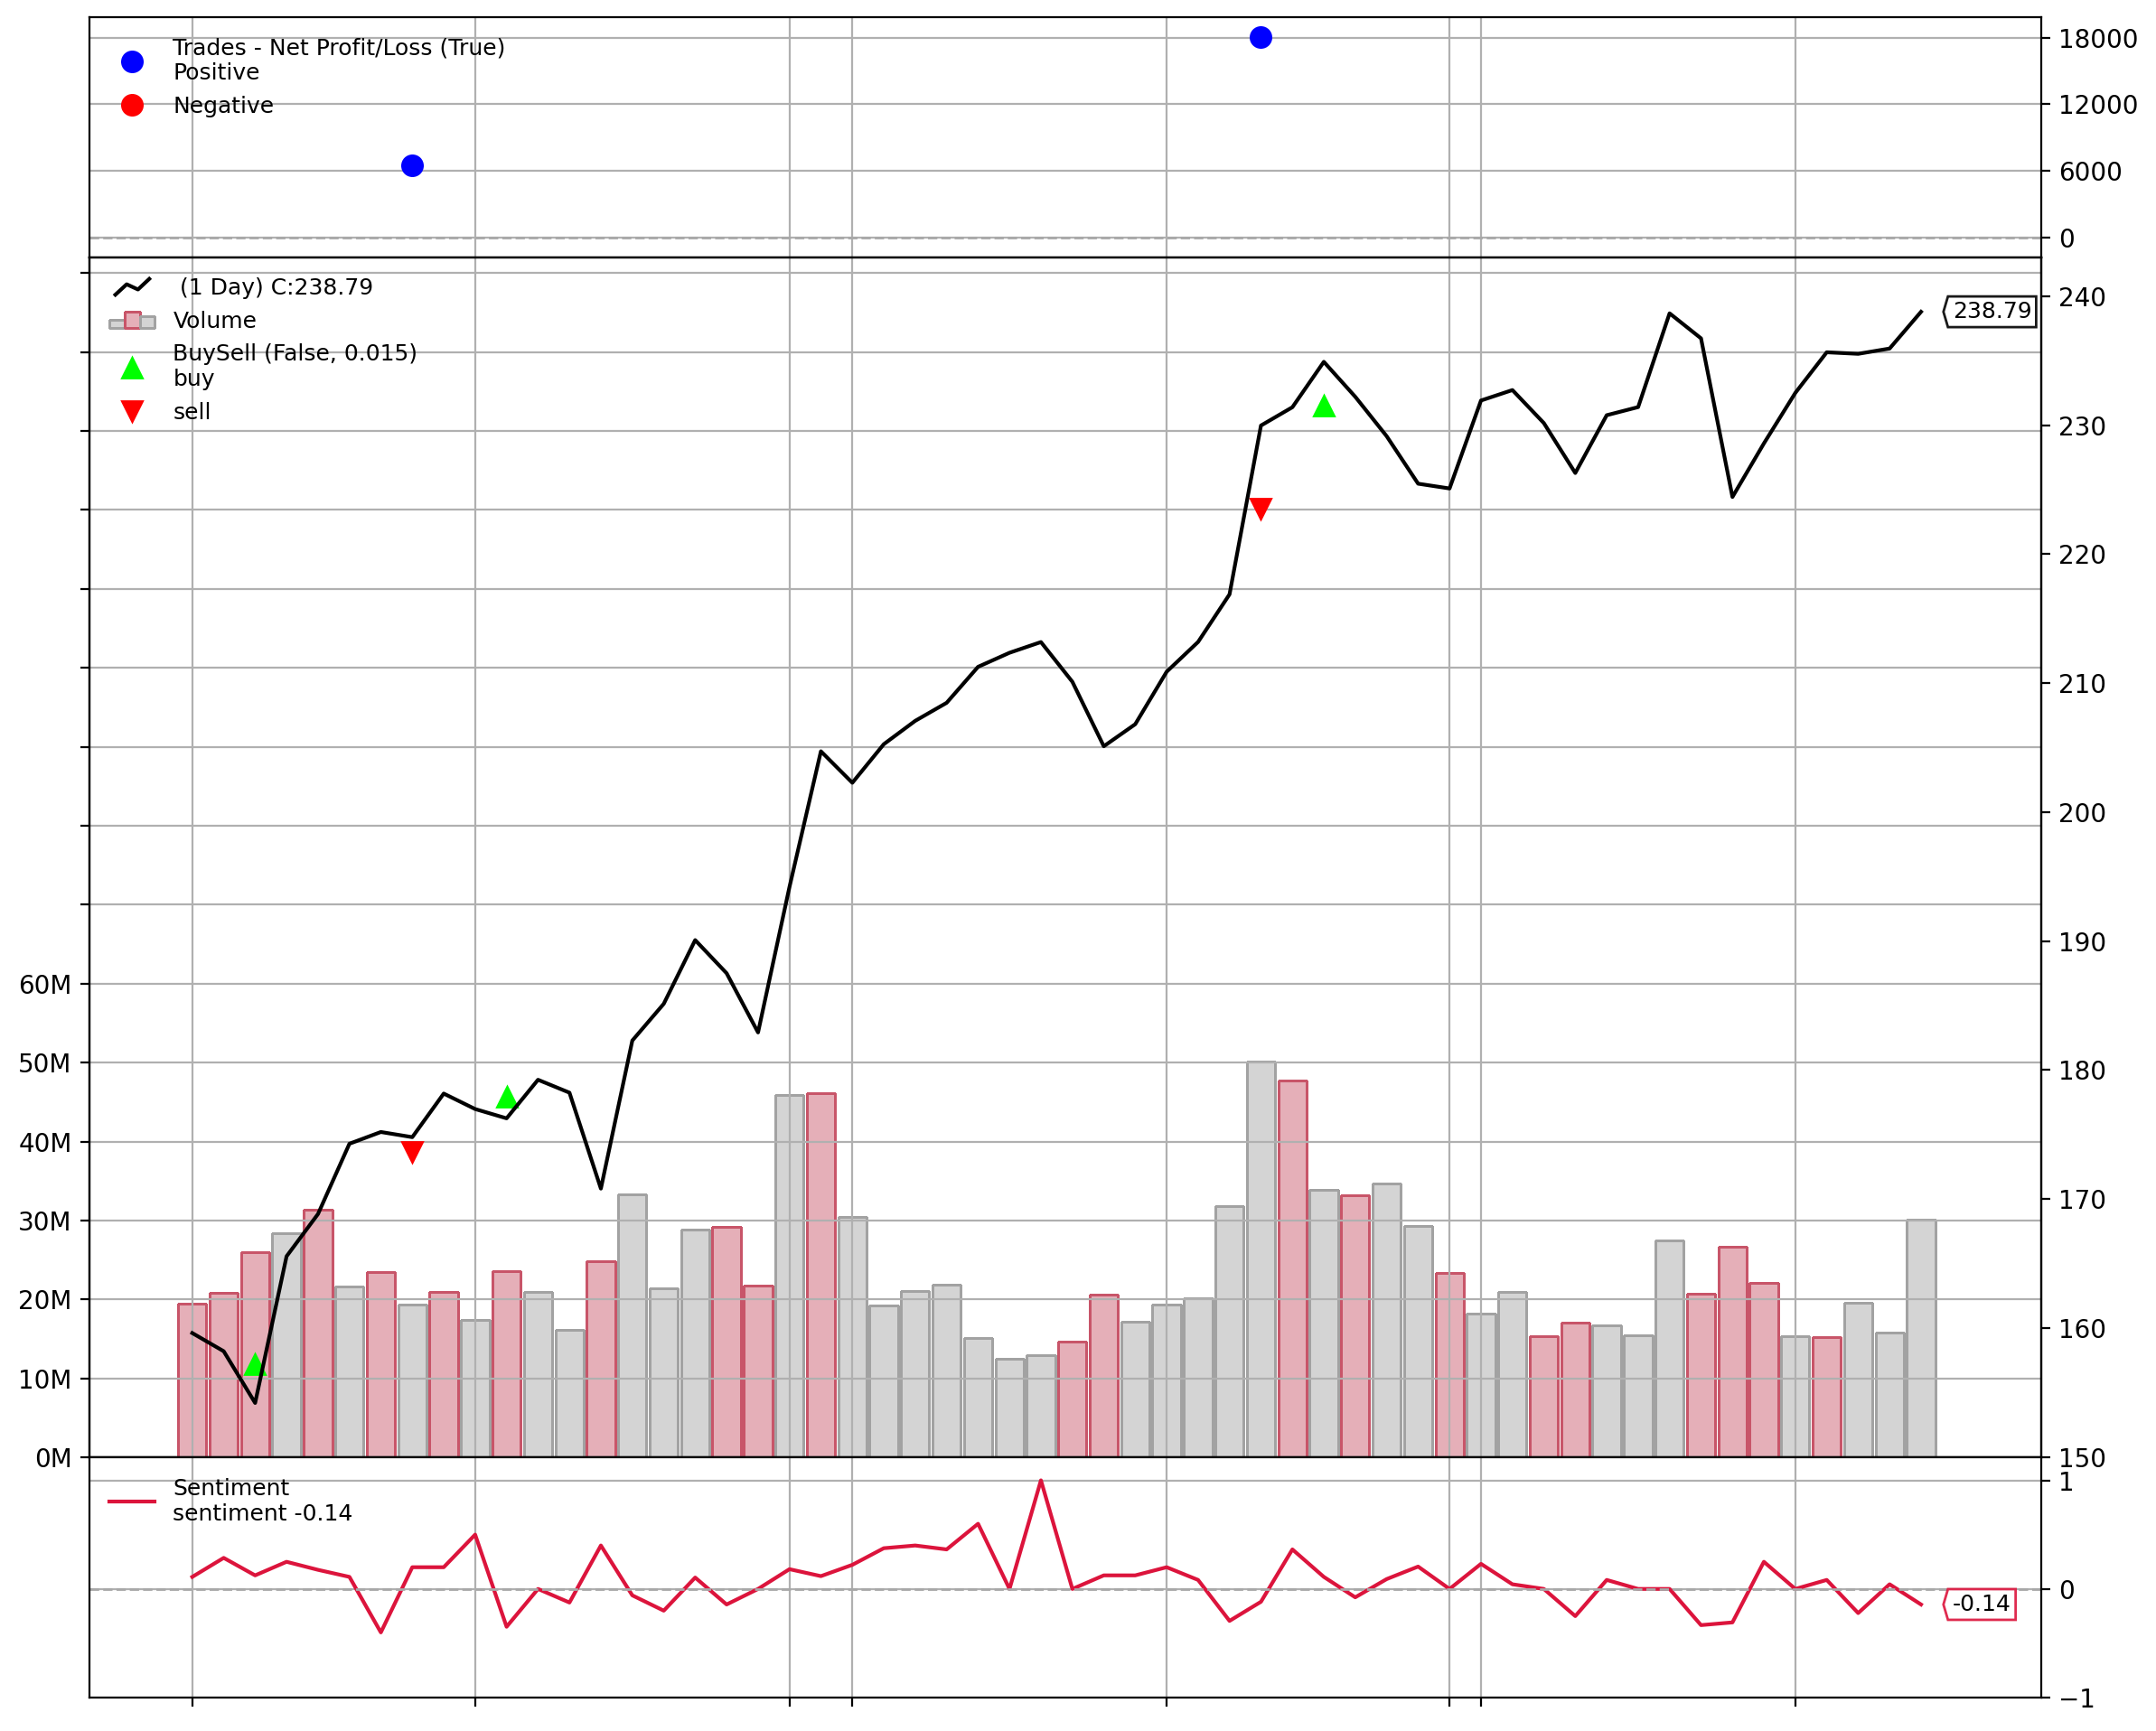

In [59]:
def saveplots(cerebro, numfigs=1, iplot=True, start=None, end=None, width=16, height=9, dpi=300, tight=True, use=None, file_path = '', **kwargs):

        from backtrader import plot
        if cerebro.p.oldsync:
            plotter = plot.Plot_OldSync(**kwargs)
        else:
            plotter = plot.Plot(**kwargs)

        figs = []
        for stratlist in cerebro.runstrats:
            for si, strat in enumerate(stratlist):
                rfig = plotter.plot(strat, figid=si * 100,
                                    numfigs=numfigs, iplot=iplot,
                                    start=start, end=end, use=use)
                figs.append(rfig)

        for fig in figs:
            for f in fig:
                f.savefig(file_path, bbox_inches='tight')
        return figs

saveplots(cerebro, file_path = 'fb_stock_over_last_4mnths.png') #run it